In [1]:
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from lmfit import Model
from pandas import read_csv
from scipy.signal import argrelextrema

import os
spec_dir = os.path.abspath("./../spec/") + "/"
plots_dir = os.path.abspath('./../plots/vorf')+'/'

import sys
module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter("ignore", category=AstropyWarning)

##################

h2_vorf = fits.open('h2_vorf.fits', ignore_missing_end=True)[0].data
h3p_vorf = fits.open('h3p_vorf.fits', ignore_missing_end=True)[0].data
h2_verr = fits.open('h2_vorf_err.fits', ignore_missing_end=True)[0].data
h3p_verr = fits.open('h3p_vorf_err.fits', ignore_missing_end=True)[0].data
h2_int = fits.open('h2_int_shifted.fits', ignore_missing_end=True)[0].data
h3p_int = fits.open('h3p_int_shifted.fits', ignore_missing_end=True)[0].data

cmlsel = read_csv('cml-sel.txt', sep='\s+', header=None)
cml = cmlsel[3].to_numpy()
sel = cmlsel[4].to_numpy()

vmp = 3.41*np.sin((185-cml)*(np.pi/180))*np.cos((sel)*(np.pi/180))

h2_vorf[h2_verr > 4] = np.nan
h3p_vorf[h3p_verr > 4] = np.nan

h2_vorf[h2_vorf > 8] = np.nan
h3p_vorf[h3p_vorf > 8] = np.nan
h2_vorf[h2_vorf < -8] = np.nan
h3p_vorf[h3p_vorf < -8] = np.nan

h2_vorf[:,:20] = np.nan
h3p_vorf[:,:20] = np.nan
h2_vorf[:,280:] = np.nan
h3p_vorf[:,280:] = np.nan

h2_verr[np.isnan(h2_vorf)] = np.nan
h3p_verr[np.isnan(h3p_vorf)] = np.nan
h2_int[np.isnan(h2_vorf)] = np.nan
h3p_int[np.isnan(h3p_vorf)] = np.nan

ang_diam = 40.58867
ang_diam/(0.1)
limb_vel = 12.572
vel_slope = limb_vel * 2 / (ang_diam/(0.1))

x = np.linspace(-150,150,301)
rot_rate = vel_slope * x

a2 = h2_vorf*(-1)
b2 = h3p_vorf*(-1)

c2 = b2 - a2
errc2 = np.sqrt((h3p_verr)**2 + (h2_verr)**2)

c3 = c2 + 0
c_min = c2 - errc2
c_max = c2 + errc2
c_max_t = c3/c_max
c_min_t = c3/c_min
c_max_t[c_max_t <0] = 0

c_min_t[c_min_t <0] = 0
m3 = c_max_t * c_min_t

m3[m3 > 0] = 1

d3 = c3 * m3
d3a = c_min * m3
d3b = c_max * m3

e3 = c3 *0
e3[d3 > 0] = c_min[d3 > 0]
e3[d3 < 0] = c_max[d3 < 0]

vcur = c2
vcurmax = vcur + errc2
vcurmin = vcur - errc2

peak11 = np.array([np.nan,96,88,81,78,78,81,84,88,93,99])
peak12 = np.array([np.nan,156,157,159,161,163,165,163])

peak21 = np.array([np.nan,101,101,101,103,112,121,127,134,140,151,155])
peak22 = np.array([np.nan,183,187,190,192,197,201,205,207,210,212,218,219,218])

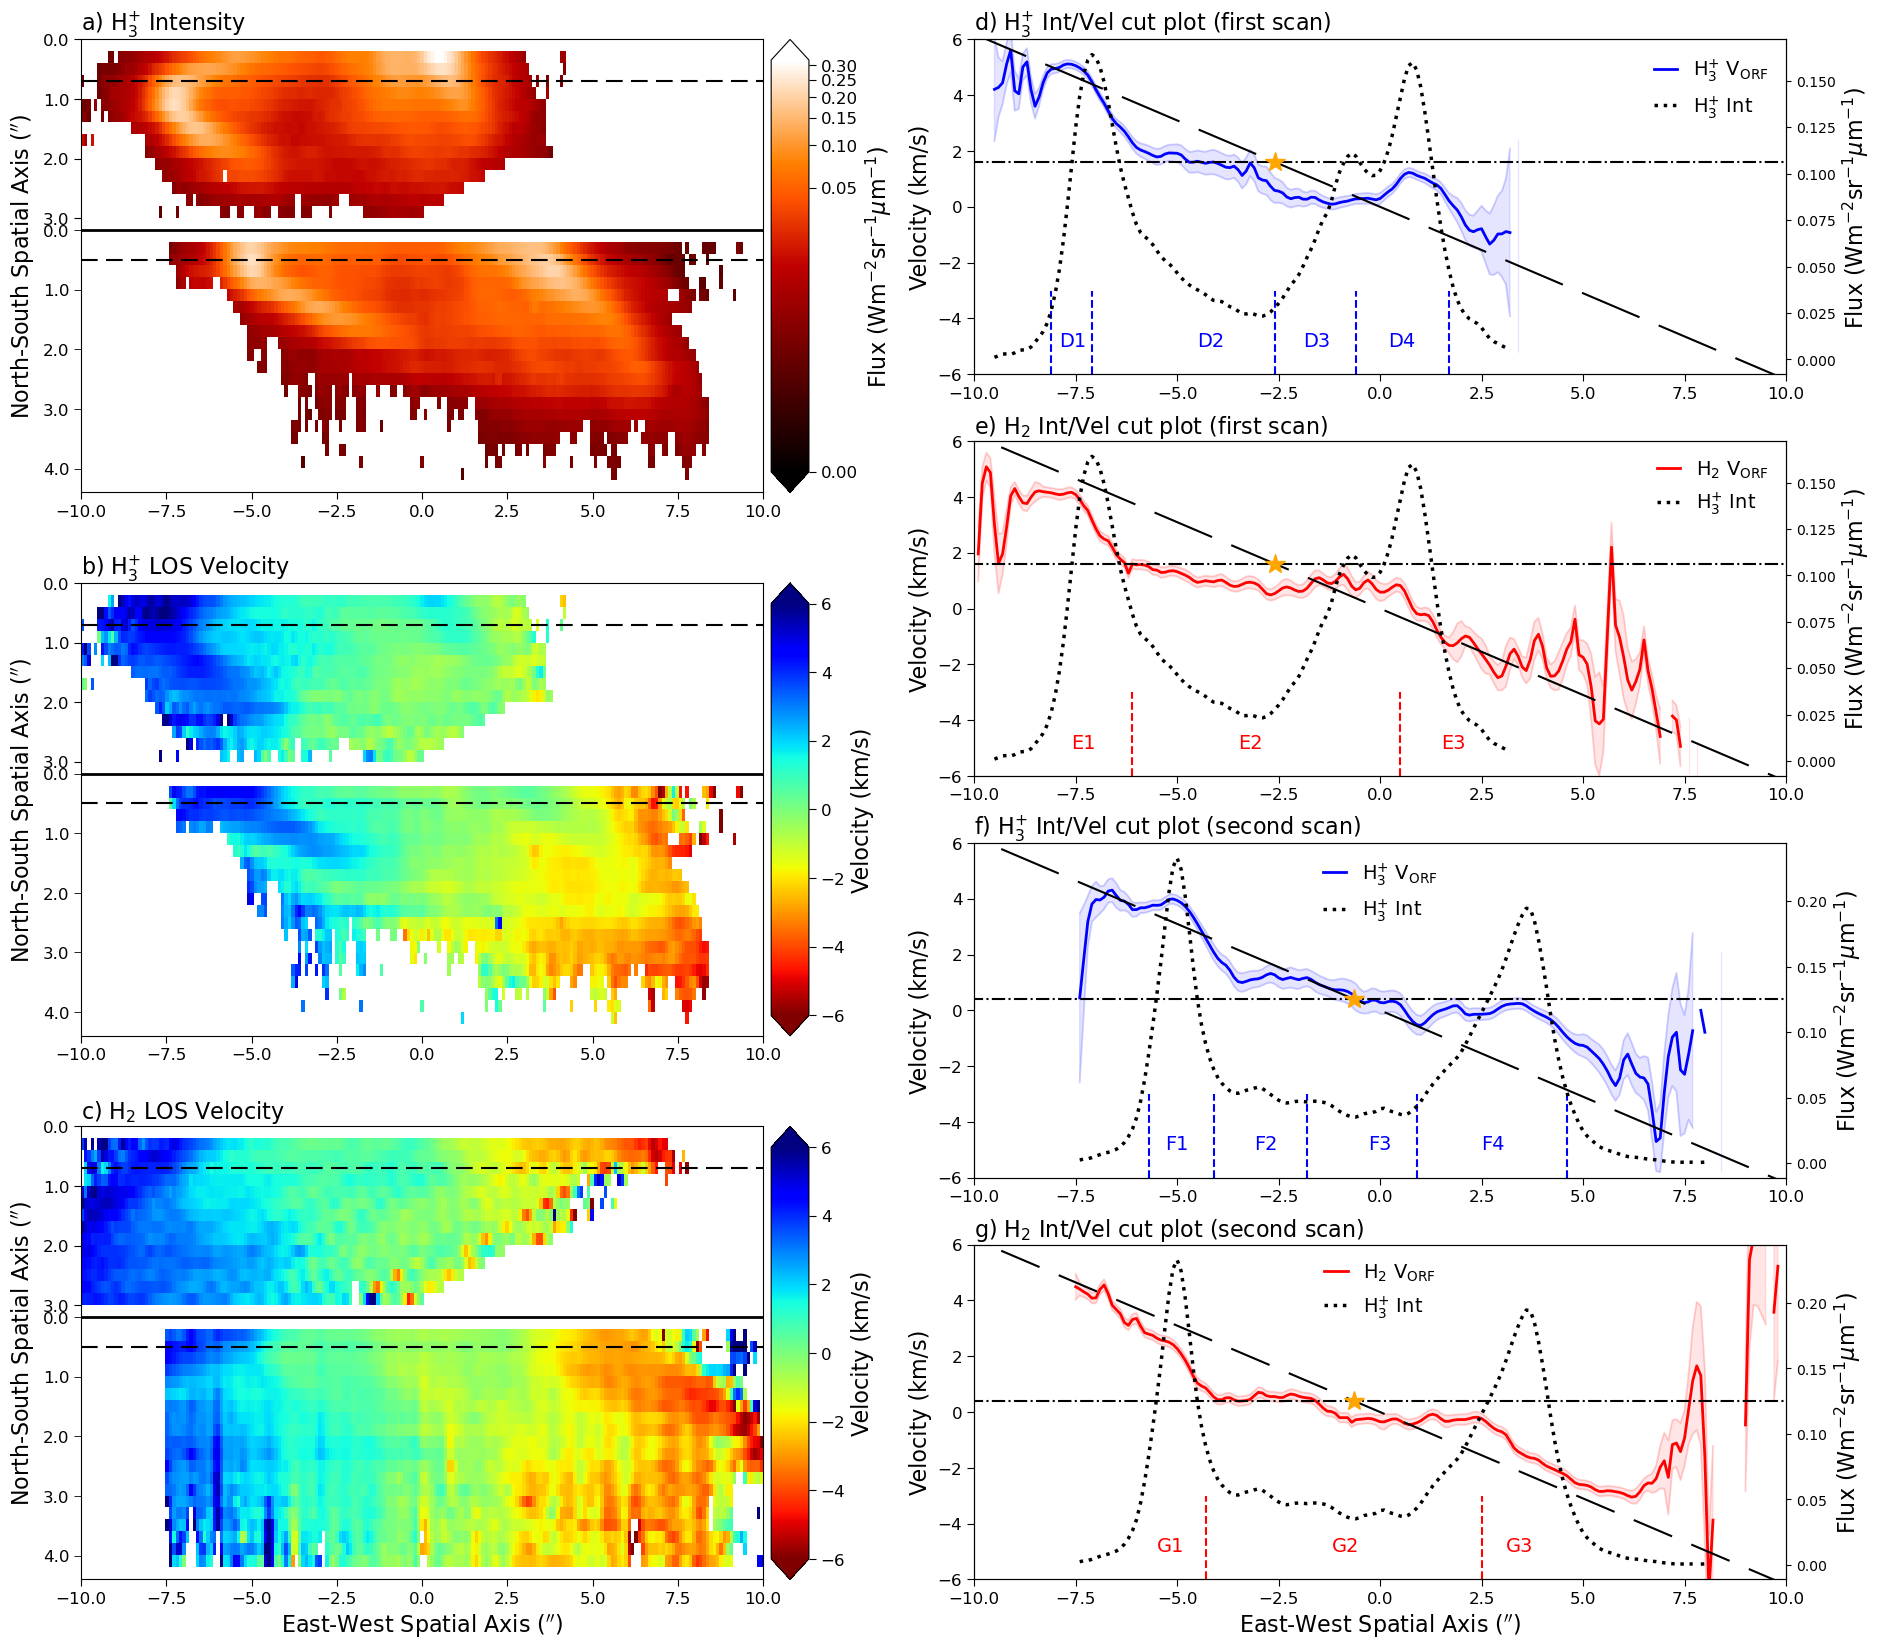

In [2]:
h3p_int_rs = ndimage.zoom(h3p_int, [2,1], order=0)
h2_vorf_rs = ndimage.zoom(a2, [2,1], order=0)
h3p_vorf_rs = ndimage.zoom(b2, [2,1], order=0)

xnew = np.linspace(-15,15,301)

fig = plt.figure(figsize=(22, 20))

ax1 = fig.add_subplot(3,2,1)
im1 = ax1.imshow(h3p_int_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='gist_heat',
           extent=[-15,15,7.6,0],
           norm=colors.PowerNorm(gamma=0.2))
ax1.set_xlim(-10,10)
ax1.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['0.0', '1.0', '2.0', '3.0'])
ax1.tick_params(axis='y', length=5, which='major', labelsize='large')
ax1.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax1.set_yticklabels(['0.0','1.0','2.0','3.0','4.0'], minor=True)
ax1.tick_params(axis='y', length=5, which='minor', labelsize='large')
# ax1.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.tick_params(axis='x', length=5, labelsize='large')
ax1.set_title('a) H$_3^{+}$ Intensity', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
cbar1 = plt.colorbar(im1, extend='both', aspect=12, pad=0.01, shrink=1)
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16)


ax2 = fig.add_subplot(3,2,3)
im2 = ax2.imshow(h3p_vorf_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-6, 
           vmax=6)
ax2.set_xlim(-10,10)
ax2.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['0.0', '1.0', '2.0', '3.0'])
ax2.tick_params(axis='y', length=5, which='major', labelsize='large')
ax2.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax2.set_yticklabels(['0.0','1.0','2.0','3.0','4.0'], minor=True)
ax2.tick_params(axis='y', length=5, which='minor', labelsize='large')
# ax2.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.tick_params(axis='x', length=5, labelsize='large')
ax2.set_title('b) H$_3^{+}$ LOS Velocity', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
cbar2 = plt.colorbar(im2, extend='both', aspect=12, pad=0.01, shrink=1)
cbar2.ax.tick_params(length=5, labelsize='large')
cbar2.set_label(label='Velocity (km/s)', size=16)


ax3 = fig.add_subplot(3,2,5)
im3 = ax3.imshow(h2_vorf_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-6, 
           vmax=6)
ax3.set_xlim(-10,10)
ax3.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax3.set_yticks([0, 1, 2, 3])
ax3.set_yticklabels(['0.0', '1.0', '2.0', '3.0'])
ax3.tick_params(axis='y', length=5, which='major', labelsize='large')
ax3.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax3.set_yticklabels(['0.0','1.0','2.0','3.0','4.0'], minor=True)
ax3.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax3.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax3.tick_params(axis='x', length=5, labelsize='large')
ax3.set_title('c) H$_2$ LOS Velocity', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
cbar3 = plt.colorbar(im3, extend='both', aspect=12, pad=0.01, shrink=1)
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label='Velocity (km/s)', size=16)


vh2 = a2[3]
vh2max = vh2 + h2_verr[3]
vh2min = vh2 - h2_verr[3]
vh3p = b2[3]
vh3pmax = vh3p + h3p_verr[3]
vh3pmin = vh3p - h3p_verr[3]
h2int = h2_int[3]
h3pint = h3p_int[3]
vh2mp = vh2 - vmp[3]
vh3pmp = vh3p - vmp[3]
polar_rate = np.zeros_like(rot_rate) + vmp[3]


ax4 = fig.add_subplot(4,2,2)
ax4.plot(xnew, vh3p, color='blue', label=r'H$_3^{+}$ V$_\mathrm{ORF}$', lw=2)
ax4.plot(xnew, vh3pmax, color='blue', alpha=0.1)
ax4.plot(xnew, vh3pmin, color='blue', alpha=0.1)
ax4.fill_between(xnew, vh3pmin, vh3pmax, color='blue', alpha=0.1)
# ax4.plot(xnew, np.roll(vh3pmp, -30), color='teal', label=r'H$_3^{+}$ V$_\mathrm{MPRM}$', lw=2)
ax4.plot(xnew, -rot_rate, color='black', ls='dashed', dashes=(30, 10), lw=1.5)
# ax4.plot(xnew, -rot_rate*0.1, color='black', ls='dashdot', lw=1.5)
ax4.plot(xnew, polar_rate, color='black', ls='dashdot', lw=1.5)
ax4.set_xlim(-10,10)
ax4.set_ylim(-6,6)
ax4.set_ylabel('Velocity (km/s)', fontsize=16)
# ax4.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax4.tick_params(axis='both', length=5, labelsize='large')
ax4.set_title('d) H$_3^{+}$ Int/Vel cut plot (first scan)', loc='left', fontsize=16)

ax4.plot([-8.1,-8.1], [-6.0,-3.0], 'b--')
ax4.plot([-7.1,-7.1], [-6.0,-3.0], 'b--')
ax4.plot([-2.6,-2.6], [-6.0,-3.0], 'b--')
ax4.plot([-0.6,-0.6], [-6.0,-3.0], 'b--')
ax4.plot([1.7,1.7], [-6.0,-3.0], 'b--')
ax4.text(-7.9, -5.0, 'D1', color='b', fontsize=14)
ax4.text(-4.5, -5.0, 'D2', color='b', fontsize=14)
ax4.text(-1.9, -5.0, 'D3', color='b', fontsize=14)
ax4.text(0.2, -5.0, 'D4', color='b', fontsize=14)
ax4.plot(-2.6, polar_rate[0], ms=15, c='orange', marker='*')

ax4a = ax4.twinx()
ax4a.plot(xnew, h3pint, color='k', ls=':', label='H$_3^{+}$ Int', lw=2.5)
ax4a.set_ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=16)

lines, labels = ax4.get_legend_handles_labels()
lines2, labels2 = ax4a.get_legend_handles_labels()
ax4.legend(lines + lines2, labels + labels2, loc='upper right', handlelength=1.2, frameon=False, fontsize=14)


ax5 = fig.add_subplot(4,2,4)
ax5.plot(xnew, vh2, color='red', label=r'H$_2$ V$_\mathrm{ORF}$', lw=2)        
ax5.plot(xnew, vh2max, color='red', alpha=0.1)
ax5.plot(xnew, vh2min, color='red', alpha=0.1)
ax5.fill_between(xnew, vh2min, vh2max, color='red', alpha=0.1)
# ax5.plot(xnew, np.roll(vh2mp, -30), color='teal', label=r'H$_2$ V$_\mathrm{MPRM}$', lw=2)
ax5.plot(xnew, -rot_rate, color='black', ls='dashed', dashes=(30, 10), lw=1.5)
# ax5.plot(xnew, -rot_rate*0.1, color='black', ls='dashdot', lw=1.5)
ax5.plot(xnew, polar_rate, color='black', ls='dashdot', lw=1.5)
ax5.set_xlim(-10,10)
ax5.set_ylim(-6,6)
ax5.tick_params(axis='both', length=5, labelsize='large')
ax5.set_ylabel('Velocity (km/s)', fontsize=16)
# ax5.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax5.set_title('e) H$_2$ Int/Vel cut plot (first scan)', loc='left', fontsize=16)

ax5.plot([-6.1,-6.1], [-6.0,-3.0], 'r--')
ax5.plot([0.5,0.5], [-6.0,-3.0], 'r--')
# ax5.plot([-2.6,-2.6], [-6.0,-3.0], 'r--')
# ax5.plot([-0.6,-0.6], [-6.0,-3.0], 'r--')
# ax5.plot([1.7,1.7], [-6.0,-3.0], 'r--')
ax5.text(-7.6, -5.0, 'E1', color='r', fontsize=14)
ax5.text(-3.5, -5.0, 'E2', color='r', fontsize=14)
ax5.text(1.5, -5.0, 'E3', color='r', fontsize=14)
# ax5.text(0.2, -5.0, 'E4', color='r', fontsize=14)
ax5.plot(-2.6, polar_rate[0], ms=15, c='orange', marker='*')

ax5a = ax5.twinx()
# ax5a.plot(xnew, h2int, color='k', ls=':', label='H$_2$ Int', lw=2.5)
ax5a.plot(xnew, h3pint, color='k', ls=':', label='H$_3^{+}$ Int', lw=2.5)
ax5a.set_ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=16)

lines, labels = ax5.get_legend_handles_labels()
lines2, labels2 = ax5a.get_legend_handles_labels()
ax5.legend(lines + lines2, labels + labels2, loc='upper right', handlelength=1.2, frameon=False, fontsize=14)


vh2 = a2[18]
vh2max = vh2 + h2_verr[18]
vh2min = vh2 - h2_verr[18]
vh3p = b2[18]
vh3pmax = vh3p + h3p_verr[18]
vh3pmin = vh3p - h3p_verr[18]
h2int = h2_int[18]
h3pint = h3p_int[18]
vh2mp = vh2 - vmp[18]
vh3pmp = vh3p - vmp[18]
polar_rate = np.zeros_like(rot_rate) + vmp[18]

ax6 = fig.add_subplot(4,2,6)
ax6.plot(xnew, vh3p, color='blue', label=r'H$_3^{+}$ V$_\mathrm{ORF}$', lw=2)
ax6.plot(xnew, vh3pmax, color='blue', alpha=0.1)
ax6.plot(xnew, vh3pmin, color='blue', alpha=0.1)
ax6.fill_between(xnew, vh3pmin, vh3pmax, color='blue', alpha=0.1)
# ax6.plot(xnew, np.roll(vh3pmp, -6), color='teal', label=r'H$_3^{+}$ V$_\mathrm{MPRM}$', lw=2)
ax6.plot(xnew, -rot_rate, color='black', ls='dashed', dashes=(30, 10), lw=1.5)
ax6.plot(xnew, polar_rate, color='black', ls='dashdot', lw=1.5)
ax6.set_xlim(-10,10)
ax6.set_ylim(-6,6)
ax6.set_ylabel('Velocity (km/s)', fontsize=16)
# ax6.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax6.tick_params(axis='both', length=5, labelsize='large')
ax6.set_title('f) H$_3^{+}$ Int/Vel cut plot (second scan)', loc='left', fontsize=16)

ax6.plot([-5.7,-5.7], [-6.0,-3.0], 'b--')
ax6.plot([-4.1,-4.1], [-6.0,-3.0], 'b--')
ax6.plot([-1.8,-1.8], [-6.0,-3.0], 'b--')
ax6.plot([0.9,0.9], [-6.0,-3.0], 'b--')
ax6.plot([4.6,4.6], [-6.0,-3.0], 'b--')
ax6.text(-5.3, -5.0, 'F1', color='b', fontsize=14)
ax6.text(-3.1, -5.0, 'F2', color='b', fontsize=14)
ax6.text(-0.3, -5.0, 'F3', color='b', fontsize=14)
ax6.text(2.5, -5.0, 'F4', color='b', fontsize=14)
ax6.plot(-0.65, polar_rate[0], ms=15, c='orange', marker='*')

ax6a = ax6.twinx()
ax6a.plot(xnew, h3pint, color='k', ls=':', label='H$_3^{+}$ Int', lw=2.5)
ax6a.set_ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=16)

lines, labels = ax6.get_legend_handles_labels()
lines2, labels2 = ax6a.get_legend_handles_labels()
ax6.legend(lines + lines2, labels + labels2, loc='upper center', handlelength=1.2, frameon=False, fontsize=14)


ax7 = fig.add_subplot(4,2,8)
ax7.plot(xnew, vh2, color='red', label=r'H$_2$ V$_\mathrm{ORF}$', lw=2)        
ax7.plot(xnew, vh2max, color='red', alpha=0.1)
ax7.plot(xnew, vh2min, color='red', alpha=0.1)
ax7.fill_between(xnew, vh2min, vh2max, color='red', alpha=0.1)
# ax7.plot(xnew, np.roll(vh2mp, -6), color='teal', label=r'H$_2$ V$_\mathrm{MPRM}$', lw=2)

ax7.plot(xnew, -rot_rate, color='black', ls='dashed', dashes=(20, 10), lw=1.5)
# ax7.plot(xnew, -rot_rate*0.1, color='r', ls='dashdot', lw=1.5)
ax7.plot(xnew, polar_rate, color='black', ls='dashdot', lw=1.5)
ax7.set_xlim(-10,10)
ax7.set_ylim(-6,6)
ax7.tick_params(axis='both', length=5, labelsize='large')
ax7.set_ylabel('Velocity (km/s)', fontsize=16)
ax7.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax7.set_title('g) H$_2$ Int/Vel cut plot (second scan)', loc='left', fontsize=16)

# ax7.plot([-5.7,-5.7], [-6.0,-3.0], 'r--')
ax7.plot([-4.3,-4.3], [-6.0,-3.0], 'r--')
# ax7.plot([-0.6,-0.6], [-6.0,-3.0], 'r--')
# ax7.plot([1.7,1.7], [-6.0,-3.0], 'r--')
ax7.plot([2.5,2.5], [-6.0,-3.0], 'r--')
ax7.text(-5.5, -5.0, 'G1', color='r', fontsize=14)
ax7.text(-1.2, -5.0, 'G2', color='r', fontsize=14)
ax7.text(3.1, -5.0, 'G3', color='r', fontsize=14)
# ax7.text(2.5, -5.0, 'G4', color='r', fontsize=14)
ax7.plot(-0.65, polar_rate[0], ms=15, c='orange', marker='*')

ax7a = ax7.twinx()
ax7a.plot(xnew, h3pint, color='k', ls=':', label='H$_3^{+}$ Int', lw=2.5)
ax7a.set_ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=16)

lines, labels = ax7.get_legend_handles_labels()
lines2, labels2 = ax7a.get_legend_handles_labels()
ax7.legend(lines + lines2, labels + labels2, loc='upper center', handlelength=1.2, frameon=False, fontsize=14)

plt.subplots_adjust(wspace=0.1)

# plt.savefig(plots_dir+'ion_neutral_drift.pdf', dpi=600, bbox_inches='tight', facecolor='white')

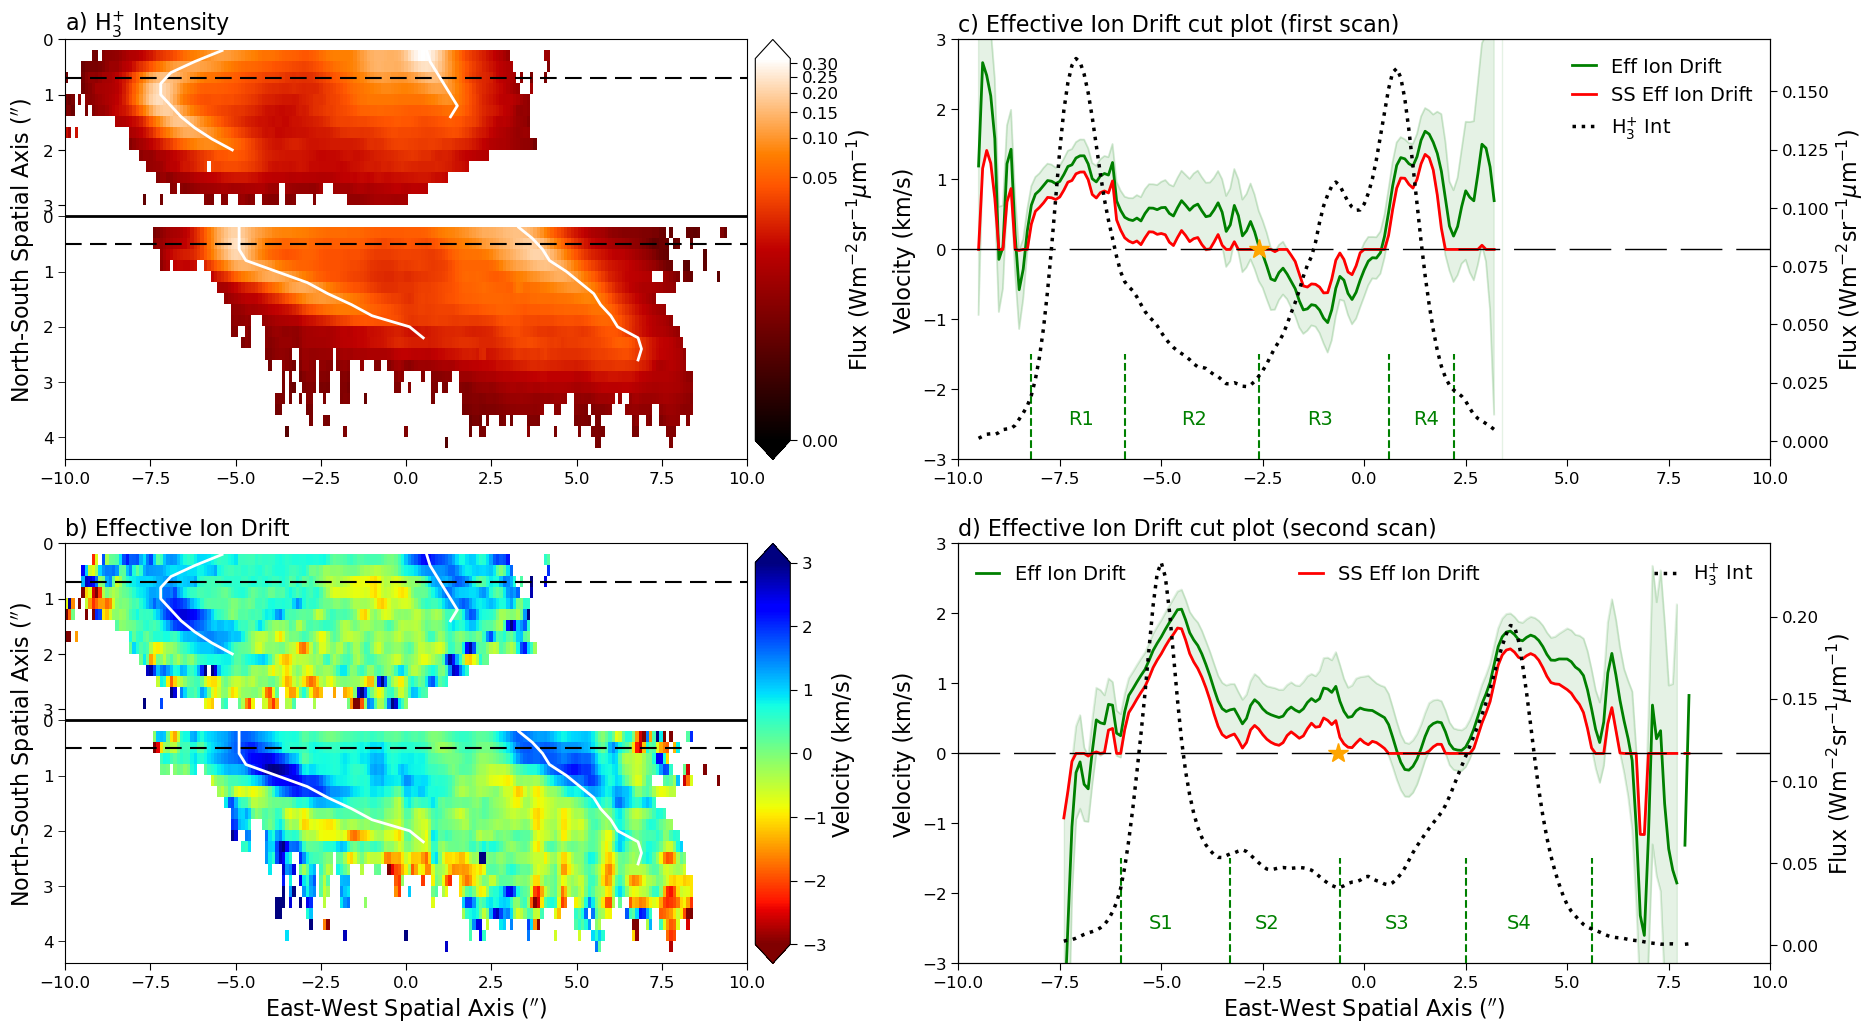

In [3]:
h3p_int_rs = ndimage.zoom(h3p_int, [2,1], order=0)
eff_ion_drift_rs = ndimage.zoom(c3, [2,1], order=0)
eff_ion_drift_ss_rs = ndimage.zoom(e3, [2,1], order=0)

xnew = np.linspace(-15,15,301)

fig = plt.figure(figsize=(22, 12))

ax1 = fig.add_subplot(2,2,1)
# ax1 = fig.add_subplot(2,3,1)
im1 = ax1.imshow(h3p_int_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='gist_heat',
#            extent=[-150, 150, 146.0669, 189.0669], 
           extent=[-15,15,7.6,0],
           norm=colors.PowerNorm(gamma=0.2))
ax1.set_xlim(-10,10)
ax1.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['0', '1', '2', '3'])
ax1.tick_params(axis='y', length=5, which='major', labelsize='large')
ax1.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax1.set_yticklabels(['0','1','2','3','4'], minor=True)
ax1.tick_params(axis='y', length=5, which='minor', labelsize='large')
# ax1.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.tick_params(axis='x', length=5, labelsize='large')
ax1.set_title('a) H$_3^{+}$ Intensity', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot((peak11-150)/10, np.array(range(0,len(peak11)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak12-150)/10, np.array(range(0,len(peak12)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak21-150)/10, np.array(range(0,len(peak21)*2,2))/10+3.2, ls='-', lw=2, color='white')
plt.plot((peak22-150)/10, np.array(range(0,len(peak22)*2,2))/10+3.2, ls='-', lw=2, color='white')
# plt.plot((peak11-150)/10, np.linspace(0,len(peak11)/10,len(peak11)), ls='-', lw=1.5, color='white')
# plt.plot((peak12-150)/10, np.linspace(0,len(peak12)/10,len(peak12)), ls='-', lw=1.5, color='white')
# plt.plot((peak21-150)/10, np.linspace(1.6,1.6+len(peak21)/10,len(peak21)), ls='-', lw=1.5, color='white')
# plt.plot((peak22-150)/10, np.linspace(1.6,1.6+len(peak22)/10,len(peak22)), ls='-', lw=1.5, color='white')
cbar1 = plt.colorbar(im1, extend='both', aspect=12, pad=0.01, shrink=1)
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label='Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', size=16)


ax2 = fig.add_subplot(2,2,3)
# ax2 = fig.add_subplot(2,3,2)
im2 = ax2.imshow(eff_ion_drift_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-3, 
           vmax=3)
ax2.set_xlim(-10,10)
ax2.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['0', '1', '2', '3'])
ax2.tick_params(axis='y', length=5, which='major', labelsize='large')
ax2.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax2.set_yticklabels(['0','1','2','3','4'], minor=True)
ax2.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax2.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.tick_params(axis='x', length=5, labelsize='large')
ax2.set_title('b) Effective Ion Drift', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot((peak11-150)/10, np.array(range(0,len(peak11)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak12-150)/10, np.array(range(0,len(peak12)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak21-150)/10, np.array(range(0,len(peak21)*2,2))/10+3.2, ls='-', lw=2, color='white')
plt.plot((peak22-150)/10, np.array(range(0,len(peak22)*2,2))/10+3.2, ls='-', lw=2, color='white')
cbar2 = plt.colorbar(im2, extend='both', aspect=12, pad=0.01, shrink=1)
cbar2.ax.tick_params(length=5, labelsize='large')
cbar2.set_label(label='Velocity (km/s)', size=16)


vcur = c2[3]
vcurmax = vcur + errc2[3]
vcurmin = vcur - errc2[3]
vmin = e3[3]
h3pint = h3p_int[3]
polar_rate = np.zeros_like(rot_rate) + vmp[3]


ax3 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,3,4)
ax3.plot(xnew, vcur, color='green', label='Eff Ion Drift', lw=2)
ax3.plot(xnew, vcurmax, color='green', alpha=0.1)
ax3.plot(xnew, vcurmin, color='green', alpha=0.1)
ax3.fill_between(xnew, vcurmin, vcurmax, color='green', alpha=0.1)
ax3.plot(xnew, vmin, color='red', ls='-', label='SS Eff Ion Drift', lw=2)
ax3.axhline(y=0, color='black', ls='dashed', dashes=(30, 10), lw=1)
# ax3.plot(xnew, polar_rate, color='black', ls='dashdot', lw=1.5)
# ax3.plot(xnew, vmp[3]+rot_rate, color='black', ls='dashdot', lw=1.5)
ax3.plot(-2.6, 0, ms=15, c='orange', marker='*')
ax3.set_xlim(-10,10)
ax3.set_ylim(-3,3)
ax3.set_ylabel('Velocity (km/s)', fontsize=16)
# ax3.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax3.tick_params(axis='both', length=5, labelsize='large')
ax3.set_title('c) Effective Ion Drift cut plot (first scan)', loc='left', fontsize=16)

ax3.plot([-8.2,-8.2], [-3.0,-1.5], 'g--')
ax3.plot([-5.9,-5.9], [-3.0,-1.5], 'g--')
ax3.plot([-2.6,-2.6], [-3.0,-1.5], 'g--')
ax3.plot([0.6,0.6], [-3.0,-1.5], 'g--')
ax3.plot([2.2,2.2], [-3.0,-1.5], 'g--')
ax3.text(-7.3, -2.5, 'R1', color='g', fontsize=14)
ax3.text(-4.5, -2.5, 'R2', color='g', fontsize=14)
ax3.text(-1.4, -2.5, 'R3', color='g', fontsize=14)
ax3.text(1.2, -2.5, 'R4', color='g', fontsize=14)

ax3a = ax3.twinx()
ax3a.plot(xnew, h3pint, color='k', ls=':', label='H$_3^{+}$ Int', lw=2.5)
ax3a.set_ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=16)
ax3a.tick_params(axis='y', length=5, labelsize='large')

lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax3a.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper right', handlelength=1.2, frameon=False, fontsize=14)




# ax3 = fig.add_subplot(2,3,4)
# im3 = ax3.imshow(eff_ion_drift_min_rs, 
#            aspect='auto', 
#            interpolation='none', 
#            cmap='jet_r', 
#            extent=[-15,15,7.6,0],
#            vmin=-4, 
#            vmax=4)
# ax3.set_xlim(-10,10)
# ax3.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
# ax3.set_yticks([0, 1, 2, 3])
# ax3.set_yticklabels(['0', '1', '2', '3'])
# ax3.tick_params(axis='y', length=5, which='major', labelsize='large')
# ax3.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
# ax3.set_yticklabels(['0','1','2','3','4'], minor=True)
# ax3.tick_params(axis='y', length=5, which='minor', labelsize='large')
# ax3.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
# ax3.tick_params(axis='x', length=5, labelsize='large')
# ax3.set_title('c)', loc='left', fontsize=16)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 5), lw=2)
# plt.plot((peak11-150)/10, np.array(range(0,len(peak11)*2,2))/10, ls='-', lw=2, color='white')
# plt.plot((peak12-150)/10, np.array(range(0,len(peak12)*2,2))/10, ls='-', lw=2, color='white')
# plt.plot((peak21-150)/10, np.array(range(0,len(peak21)*2,2))/10+3.2, ls='-', lw=2, color='white')
# plt.plot((peak22-150)/10, np.array(range(0,len(peak22)*2,2))/10+3.2, ls='-', lw=2, color='white')
# cbar3 = plt.colorbar(im3, extend='both', aspect=12, pad=0.01, shrink=1)
# cbar3.ax.tick_params(length=5, labelsize='large')
# cbar3.set_label(label='Effective Ion Drift (km/s)', size=16)

cut_b = 18

vcur = c2[cut_b]
vcurmax = vcur + errc2[cut_b]
vcurmin = vcur - errc2[cut_b]
vmin = e3[cut_b]
h3pint = h3p_int[cut_b]
polar_rate = np.zeros_like(rot_rate) + vmp[cut_b]


ax4 = fig.add_subplot(2,2,4)
# ax4 = fig.add_subplot(2,3,5)
ax4.plot(xnew, vcur, color='green', label='Eff Ion Drift', lw=2)
ax4.plot(xnew, vcurmax, color='green', alpha=0.1)
ax4.plot(xnew, vcurmin, color='green', alpha=0.1)
ax4.fill_between(xnew, vcurmin, vcurmax, color='green', alpha=0.1)
ax4.plot(xnew, vmin, color='red', ls='-', label='SS Eff Ion Drift', lw=2)
ax4.axhline(y=0, color='black', ls='dashed', dashes=(30, 10), lw=1)
# ax4.plot(xnew, polar_rate, color='black', ls='dashdot', lw=1.5)
# ax4.plot(xnew, vmp[18]+rot_rate, color='black', ls='dashdot', lw=1.5)
ax4.plot(-0.65, 0, ms=15, c='orange', marker='*')
ax4.set_xlim(-10,10)
ax4.set_ylim(-3,3)
ax4.set_ylabel('Velocity (km/s)', fontsize=16)
ax4.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax4.tick_params(axis='both', length=5, labelsize='large')
ax4.set_title('d) Effective Ion Drift cut plot (second scan)', loc='left', fontsize=16)

ax4.plot([-6.0,-6.0], [-3.0,-1.5], 'g--')
ax4.plot([-3.3,-3.3], [-3.0,-1.5], 'g--')
ax4.plot([-0.6,-0.6], [-3.0,-1.5], 'g--')
ax4.plot([2.5,2.5], [-3.0,-1.5], 'g--')
ax4.plot([5.6,5.6], [-3.0,-1.5], 'g--')
ax4.text(-5.3, -2.5, 'S1', color='g', fontsize=14)
ax4.text(-2.7, -2.5, 'S2', color='g', fontsize=14)
ax4.text(0.5, -2.5, 'S3', color='g', fontsize=14)
ax4.text(3.5, -2.5, 'S4', color='g', fontsize=14)

ax4a = ax4.twinx()
ax4a.plot(xnew, h3pint, color='k', ls=':', label='H$_3^{+}$ Int', lw=2.5)
ax4a.set_ylabel('Flux (Wm$^{-2}$sr$^{-1}$$\mu$m$^{-1}$)', fontsize=16)
ax4a.tick_params(axis='y', length=5, labelsize='large')

lines, labels = ax4.get_legend_handles_labels()
lines2, labels2 = ax4a.get_legend_handles_labels()
ax4.legend(lines + lines2, labels + labels2, loc='upper center', ncols=3, mode='expand', handlelength=1.2, frameon=False, fontsize=14)

plt.subplots_adjust(wspace=0.1)

# plt.savefig(plots_dir+'eff_ion_drift.pdf', dpi=600, bbox_inches='tight', facecolor='white')

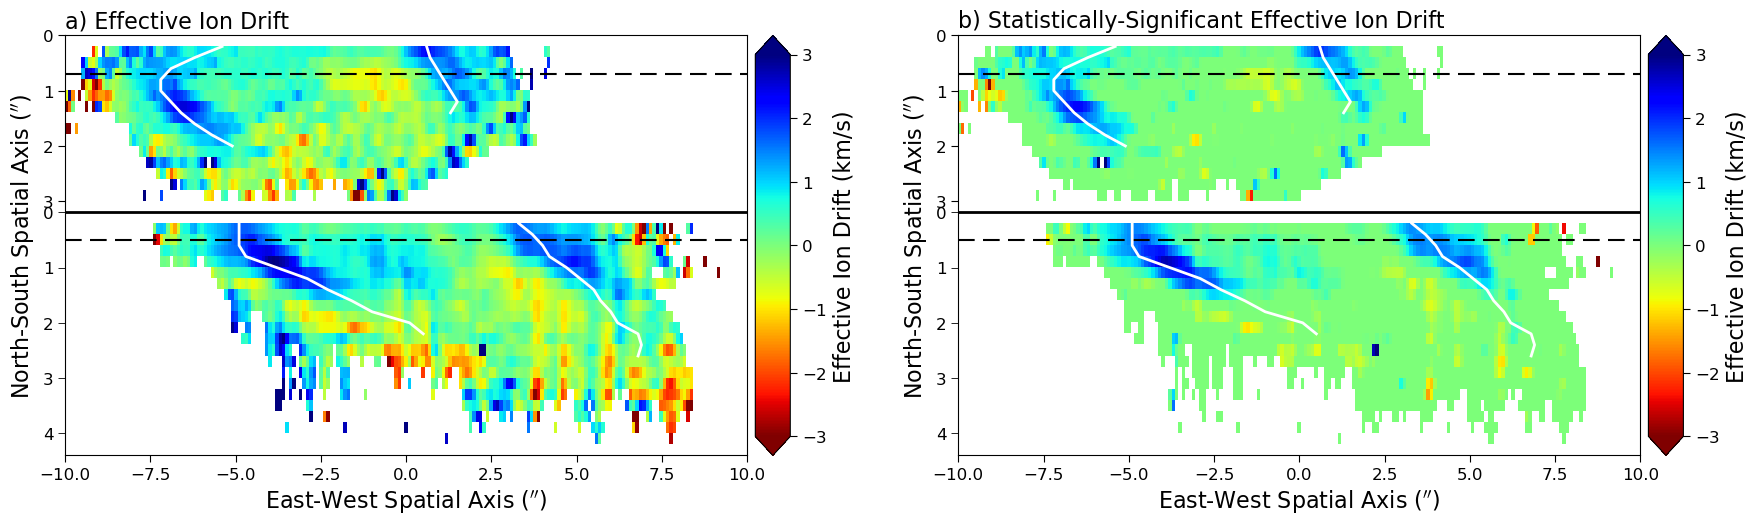

In [4]:
fig = plt.figure(figsize=(22, 12))

ax1 = fig.add_subplot(2,2,1)
im1 = ax1.imshow(eff_ion_drift_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-3, 
           vmax=3)
ax1.set_xlim(-10,10)
ax1.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['0', '1', '2', '3'])
ax1.tick_params(axis='y', length=5, which='major', labelsize='large')
ax1.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax1.set_yticklabels(['0','1','2','3','4'], minor=True)
ax1.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax1.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.tick_params(axis='x', length=5, labelsize='large')
ax1.set_title('a) Effective Ion Drift', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot((peak11-150)/10, np.array(range(0,len(peak11)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak12-150)/10, np.array(range(0,len(peak12)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak21-150)/10, np.array(range(0,len(peak21)*2,2))/10+3.2, ls='-', lw=2, color='white')
plt.plot((peak22-150)/10, np.array(range(0,len(peak22)*2,2))/10+3.2, ls='-', lw=2, color='white')
cbar2 = plt.colorbar(im1, extend='both', aspect=12, pad=0.01, shrink=1)
cbar2.ax.tick_params(length=5, labelsize='large')
cbar2.set_label(label='Effective Ion Drift (km/s)', size=16)

ax2 = fig.add_subplot(2,2,2)
im2 = ax2.imshow(eff_ion_drift_ss_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-3, 
           vmax=3)
ax2.set_xlim(-10,10)
ax2.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['0', '1', '2', '3'])
ax2.tick_params(axis='y', length=5, which='major', labelsize='large')
ax2.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax2.set_yticklabels(['0','1','2','3','4'], minor=True)
ax2.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax2.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.tick_params(axis='x', length=5, labelsize='large')
ax2.set_title('b) Statistically-Significant Effective Ion Drift', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot((peak11-150)/10, np.array(range(0,len(peak11)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak12-150)/10, np.array(range(0,len(peak12)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak21-150)/10, np.array(range(0,len(peak21)*2,2))/10+3.2, ls='-', lw=2, color='white')
plt.plot((peak22-150)/10, np.array(range(0,len(peak22)*2,2))/10+3.2, ls='-', lw=2, color='white')
cbar2 = plt.colorbar(im2, extend='both', aspect=12, pad=0.01, shrink=1)
cbar2.ax.tick_params(length=5, labelsize='large')
cbar2.set_label(label='Effective Ion Drift (km/s)', size=16)

plt.subplots_adjust(wspace=0.1)

# plt.savefig(plots_dir+'ss_eff_ion_drift.pdf', dpi=600, bbox_inches='tight', facecolor='white')

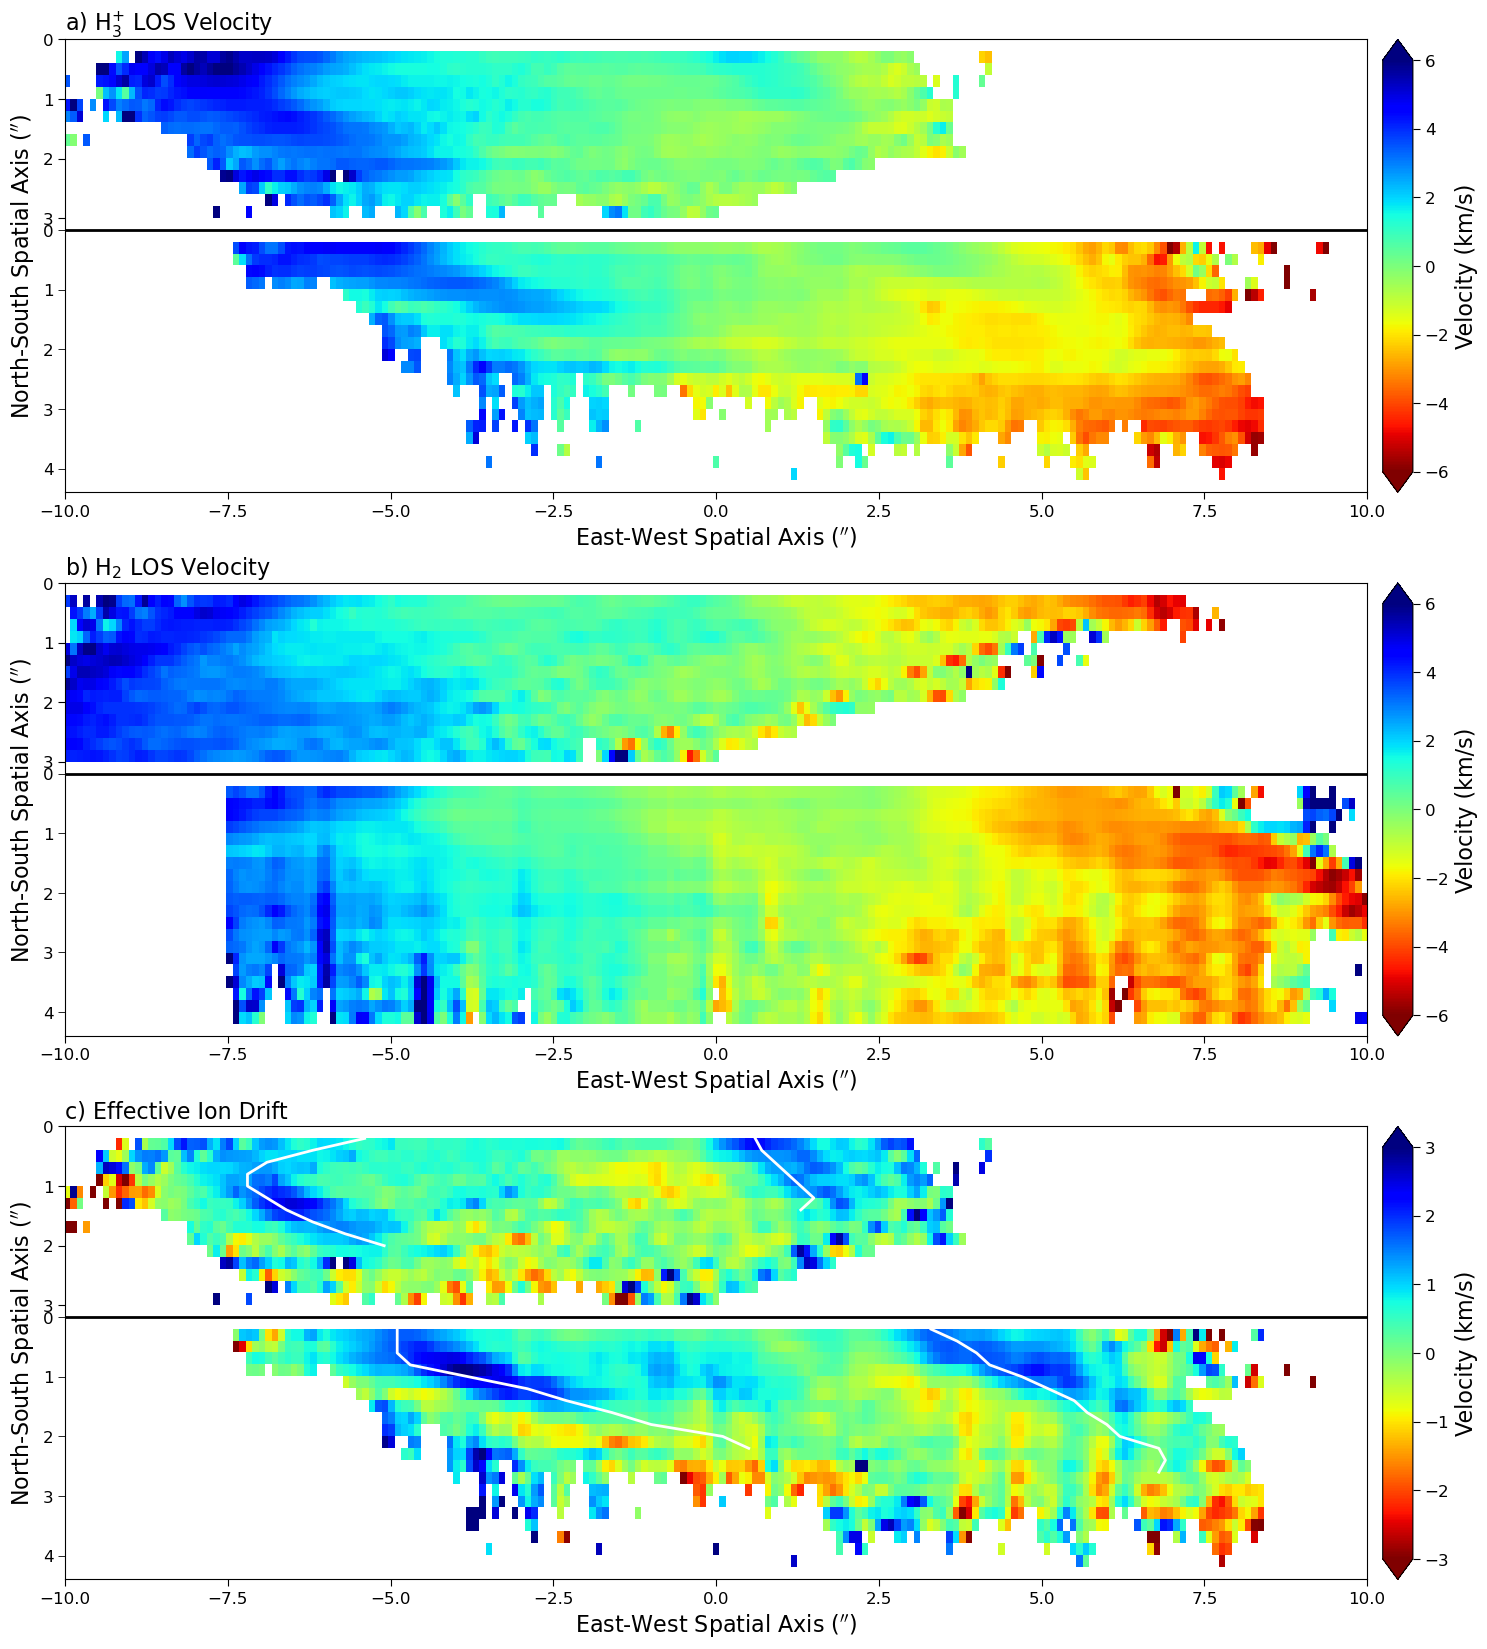

In [35]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(3,1,1)
im1 = ax1.imshow(h3p_vorf_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-6, 
           vmax=6)
ax1.set_xlim(-10,10)
ax1.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['0', '1', '2', '3'])
ax1.tick_params(axis='y', length=5, which='major', labelsize='large')
ax1.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax1.set_yticklabels(['0','1','2','3','4'], minor=True)
ax1.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax1.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax1.tick_params(axis='x', length=5, labelsize='large')
ax1.set_title('a) H$_3^{+}$ LOS Velocity', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
cbar1 = plt.colorbar(im1, extend='both', aspect=15, pad=0.01, shrink=1)
cbar1.ax.tick_params(length=5, labelsize='large')
cbar1.set_label(label='Velocity (km/s)', size=16)

ax2 = fig.add_subplot(3,1,2)
im2 = ax2.imshow(h2_vorf_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-6, 
           vmax=6)
ax2.set_xlim(-10,10)
ax2.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.set_yticks([0, 1, 2, 3])
ax2.set_yticklabels(['0', '1', '2', '3'])
ax2.tick_params(axis='y', length=5, which='major', labelsize='large')
ax2.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax2.set_yticklabels(['0','1','2','3','4'], minor=True)
ax2.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax2.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax2.tick_params(axis='x', length=5, labelsize='large')
ax2.set_title('b) H$_2$ LOS Velocity', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
cbar2 = plt.colorbar(im2, extend='both', aspect=15, pad=0.01, shrink=1)
cbar2.ax.tick_params(length=5, labelsize='large')
cbar2.set_label(label='Velocity (km/s)', size=16)

ax3 = fig.add_subplot(3,1,3)
im3 = ax3.imshow(eff_ion_drift_rs, 
           aspect='auto', 
           interpolation='none', 
           cmap='jet_r', 
           extent=[-15,15,7.6,0],
           vmin=-3, 
           vmax=3)
ax3.set_xlim(-10,10)
ax3.set_ylabel('North-South Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax3.set_yticks([0, 1, 2, 3])
ax3.set_yticklabels(['0', '1', '2', '3'])
ax3.tick_params(axis='y', length=5, which='major', labelsize='large')
ax3.set_yticks([3.2, 4.2, 5.2, 6.2, 7.2], minor=True)
ax3.set_yticklabels(['0','1','2','3','4'], minor=True)
ax3.tick_params(axis='y', length=5, which='minor', labelsize='large')
ax3.set_xlabel('East-West Spatial Axis ($^{\prime\prime}$)', fontsize=16)
ax3.tick_params(axis='x', length=5, labelsize='large')
ax3.set_title('c) Effective Ion Drift', loc='left', fontsize=16)
plt.axhline(y=3.2, color='black', ls='solid', lw=2)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*0.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
# plt.plot(np.linspace(-10,10,201),np.ones(201)*3.7, color='black', ls='dashed', dashes=(8, 4), lw=1.5)
plt.plot((peak11-150)/10, np.array(range(0,len(peak11)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak12-150)/10, np.array(range(0,len(peak12)*2,2))/10, ls='-', lw=2, color='white')
plt.plot((peak21-150)/10, np.array(range(0,len(peak21)*2,2))/10+3.2, ls='-', lw=2, color='white')
plt.plot((peak22-150)/10, np.array(range(0,len(peak22)*2,2))/10+3.2, ls='-', lw=2, color='white')
cbar3 = plt.colorbar(im3, extend='both', aspect=15, pad=0.01, shrink=1)
cbar3.ax.tick_params(length=5, labelsize='large')
cbar3.set_label(label='Velocity (km/s)', size=16)

plt.subplots_adjust(wspace=0.1)

# plt.savefig(plots_dir+'20240326_Wang.png', dpi=400, bbox_inches='tight')

In [8]:
hdu_ion_drift = fits.PrimaryHDU(b2)
hdu_ion_drift.writeto('ion_drift.fits', overwrite=True)

hdu_ion_drift_errs = fits.PrimaryHDU(h3p_verr)
hdu_ion_drift_errs.writeto('ion_drift_errs.fits', overwrite=True)

hdu_neutral_drift = fits.PrimaryHDU(a2)
hdu_neutral_drift.writeto('neutral_drift.fits', overwrite=True)

hdu_neutral_drift_errs = fits.PrimaryHDU(h2_verr)
hdu_neutral_drift_errs.writeto('neutral_drift_errs.fits', overwrite=True)

hdu_eff_ion_drift = fits.PrimaryHDU(c3)
hdu_eff_ion_drift.writeto('eff_ion_drift.fits', overwrite=True)

hdu_eff_ion_drift_errs = fits.PrimaryHDU(errc2)
hdu_eff_ion_drift_errs.writeto('eff_ion_drift_errs.fits', overwrite=True)

hdu_eff_ion_drift_ss = fits.PrimaryHDU(e3)
hdu_eff_ion_drift_ss.writeto('eff_ion_drift_ss.fits', overwrite=True)

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan -8.87734950e+00
 -1.30758655e+01             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan -1.15229423e+01             nan
             nan             nan             nan             nan
 -2.60995705e+00             nan -2.70901714e+00             nan
             nan             nan             nan -1.67432992e+00
 -1.54200436e+00 -1.31805714e+00 -5.81366227e-01 -1.95450047e-02
 -1.41477513e+00 -1.46281

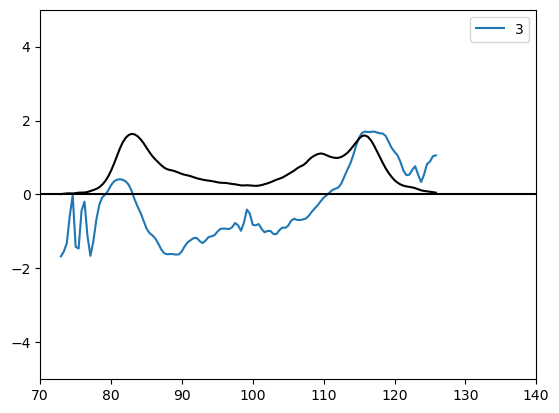

In [4]:
plt.plot(np.linspace(50,175,301), b2[3] + rot_rate, label='3')
# plt.plot(np.linspace(40,165,301), b2[18] + rot_rate, label='18')
plt.plot(np.linspace(50,175,301),h3p_int[3]*10, c='k')
plt.axhline(0,c='k')
plt.legend()
plt.xlim(70,140)
plt.ylim(-5,5)

print(b2[3] + rot_rate)

In [2]:
rot_rate[123]

-1.672604694856964

In [39]:
40.59*np.cos(74*(np.pi/180))*np.sin((178-185)*(np.pi/180))/2

-0.6817444357805218

In [4]:
np.mean((81,159))

120.0

In [40]:
np.mean((101,187))

144.0

In [35]:
pole_rate[143]

0.04336382542221759

In [42]:
pole_rate[119]

0.19203979829839216

In [36]:
pole_rate = -rot_rate*0.1
polar_rate = pole_rate - pole_rate[143] + vmp[18]

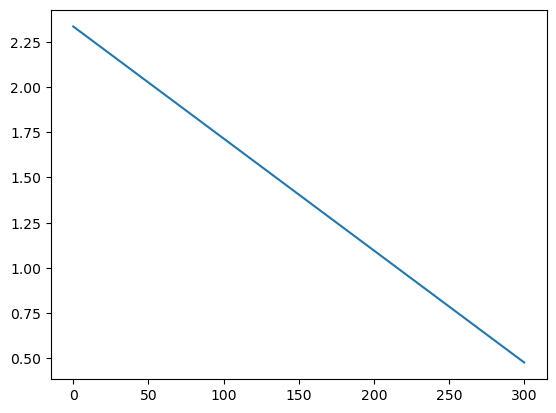

In [43]:
pole_rate = -rot_rate*0.1
polar_rate = pole_rate - pole_rate[119] + vmp[3]
plt.plot(polar_rate)

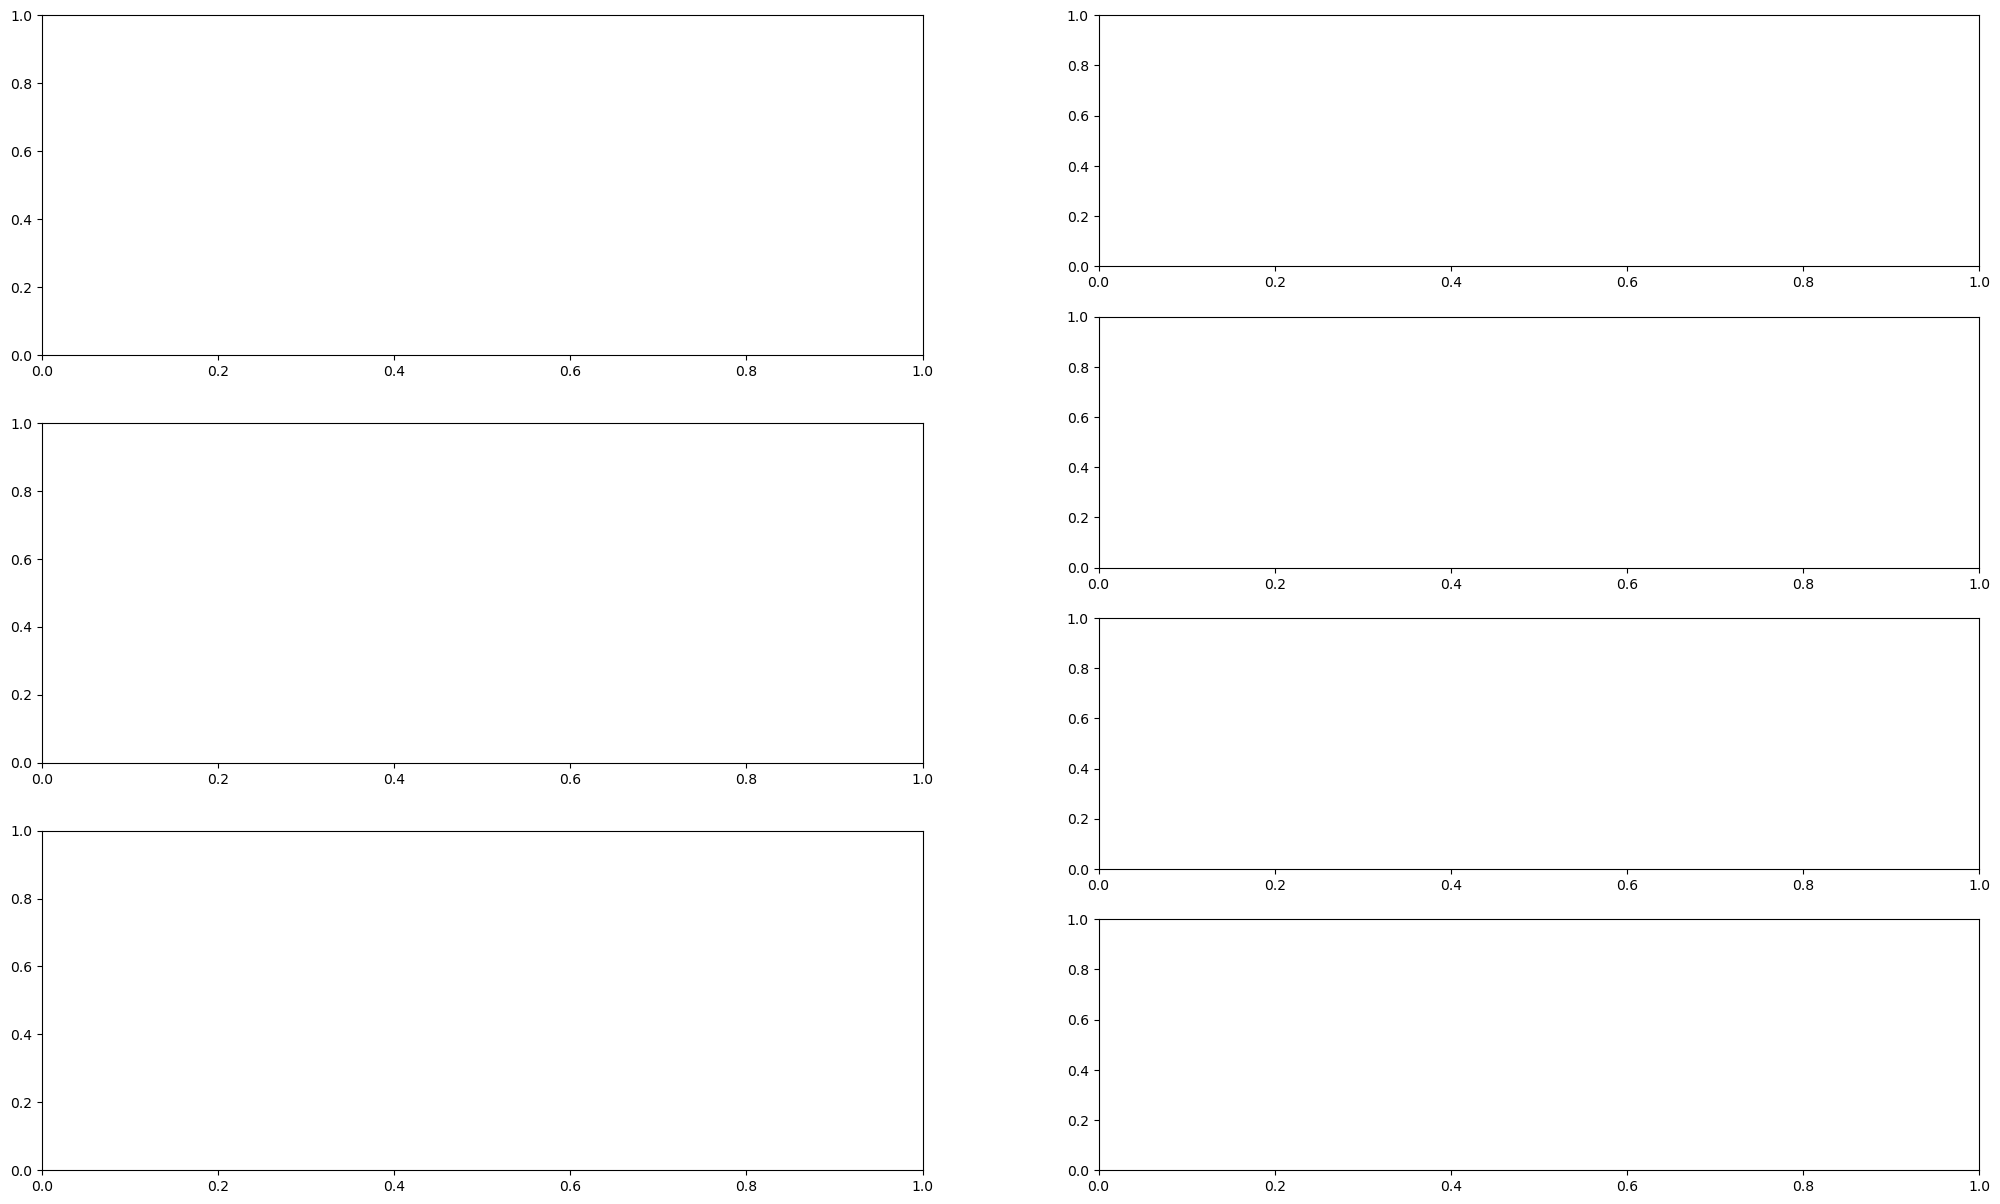

In [11]:
fig = plt.figure(figsize=(25, 15))

ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,3)
ax3 = fig.add_subplot(3,2,5)
ax4 = fig.add_subplot(4,2,2)
ax5 = fig.add_subplot(4,2,4)
ax6 = fig.add_subplot(4,2,6)
ax7 = fig.add_subplot(4,2,8)

plt.subplots_adjust()